# **Load Dataset**

In [1]:
# library dasar
import os
import pandas as pd
from PIL import Image

# library PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# load data set
class EmotionDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform

        assert "image" in self.df.columns
        assert "label" in self.df.columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["image"]
        
        # label asli (1–7)
        label_raw = int(self.df.iloc[idx]["label"])
        
        # convert ke 0–6 untuk CrossEntropyLoss
        label = label_raw - 1

        # path gambar (tetap pakai folder label 1–7)
        img_path = os.path.join(self.root_dir, str(label_raw), img_name)

        # load gambar
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
def get_dataloaders(batch_size=32):
    # transformasi untuk semua gambar
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ubah ukuran gambar
        transforms.ToTensor(),          # ubah ke tensor
    ])

    # dataset untuk train
    train_dataset = EmotionDataset(
        root_dir="train",
        csv_file="train_labels.csv",
        transform=transform
    )

    # dataset untuk test
    test_dataset = EmotionDataset(
        root_dir="test",
        csv_file="test_labels.csv",
        transform=transform
    )

    # loader untuk mini-batch training
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # loader untuk test (tidak di-shuffle)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [4]:
# load data
train_loader, test_loader = get_dataloaders(batch_size=32)

# ambil 1 batch
images, labels = next(iter(train_loader))

print("Ukuran batch gambar:", images.shape)  # harus (32, 3, 224, 224)
print("Label batch:", labels[:10])           # tampilkan 10 label pertama


Ukuran batch gambar: torch.Size([32, 3, 224, 224])
Label batch: tensor([4, 6, 3, 2, 3, 5, 4, 3, 6, 3])


# **Modeling**

In [5]:
# import
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

In [6]:
# Model ResNet18
def build_model(num_classes=7):
    # load ResNet18 pretrained
    model = resnet18(weights='IMAGENET1K_V1')
    
    # ganti fully connected layer terakhir
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

In [7]:
# Inisialisasi Model + Loss + Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = build_model(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Using device: cpu


In [8]:
# trainning loop 
def train(model, train_loader, test_loader, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # hitung akurasi training
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total

        # evaluasi setiap epoch
        test_acc = evaluate(model, test_loader)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {total_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Test Acc: {test_acc:.2f}%")

    return model


In [9]:
# Function Evaluasi
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total


In [11]:
# Training
train_loader, test_loader = get_dataloaders(batch_size=32)

model = train(model, train_loader, test_loader, epochs=10)


Epoch [1/10] Loss: 332.0976 | Train Acc: 69.28% | Test Acc: 77.90%
Epoch [2/10] Loss: 228.5831 | Train Acc: 79.20% | Test Acc: 77.54%
Epoch [3/10] Loss: 158.0713 | Train Acc: 85.68% | Test Acc: 80.05%
Epoch [4/10] Loss: 111.6042 | Train Acc: 89.86% | Test Acc: 79.43%
Epoch [5/10] Loss: 77.0442 | Train Acc: 92.92% | Test Acc: 80.93%
Epoch [6/10] Loss: 56.0994 | Train Acc: 94.78% | Test Acc: 82.53%
Epoch [7/10] Loss: 40.8814 | Train Acc: 96.33% | Test Acc: 82.30%
Epoch [8/10] Loss: 24.0802 | Train Acc: 97.76% | Test Acc: 81.16%
Epoch [9/10] Loss: 29.9332 | Train Acc: 97.16% | Test Acc: 81.19%
Epoch [10/10] Loss: 26.3668 | Train Acc: 97.59% | Test Acc: 83.02%


In [12]:
# Save Model
torch.save(model.state_dict(), "emotion_resnet18.pth")
print("Model saved!")


Model saved!


In [10]:
import torch
from torchvision.models import resnet18
import torch.nn as nn

num_classes = 7

# Build ulang model kosong
model_export = resnet18(weights='IMAGENET1K_V1')
model_export.fc = nn.Linear(model_export.fc.in_features, num_classes)

# Load trained weight
model_export.load_state_dict(torch.load("emotion_resnet18.pth", map_location="cpu"))
model_export.eval()

print("Model loaded for export")


Model loaded for export


In [4]:
pip install onnx onnxruntime onnxscript


     ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/16.5 MB 1.4 MB/s eta 0:00:13
     --------------------------------------- 0.1/16.5 MB 871.5 kB/s eta 0:00:19
     --------------------------------------- 0.1/16.5 MB 901.1 kB/s eta 0:00:19
      --------------------------------------- 0.2/16.5 MB 1.3 MB/s eta 0:00:13
      --------------------------------------- 0.3/16.5 MB 1.2 MB/s eta 0:00:14
      --------------------------------------- 0.4/16.5 MB 1.3 MB/s eta 0:00:13
     - -------------------------------------- 0.4/16.5 MB 1.3 MB/s eta 0:00:12
     - -------------------------------------- 0.4/16.5 MB 1.3 MB/s eta 0:00:13
     - -------------------------------------- 0.5/16.5 MB 1.1 MB/s eta 0:00:16
     - -------------------------------------- 0.6/16.5 MB 1.3 MB/s eta 0:00:13
     - -------------------------------------- 0.6/16.5 MB 1.2 MB/s eta 0:00:13
     - -------------------------------------- 0.7/16.5 MB


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: C:\Users\albert\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
dummy_input = torch.randn(1, 3, 224, 224)

torch.onnx.export(
    model_export,
    dummy_input,
    "emotion_resnet18.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=12,
    do_constant_folding=True
)

print("Exported to emotion_resnet18.onnx")


W1206 21:49:15.294000 26032 torch\onnx\_internal\exporter\_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 12 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 12).
Failed to convert the model to the target version 12 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "C:\Users\albert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\onnxscript\version_converter\__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
  File "C:\Users\albert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\onnxscript\version_converter\_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
  File "C:\Users\albert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\onnxscript\version_converter\__i

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
Exported to emotion_resnet18.onnx


In [11]:
# EVALUASI & INFERENCE 

# build model 
model = build_model(num_classes=7)

# load trained weight
state = torch.load("emotion_resnet18.pth", map_location=device)
model.load_state_dict(state)

model = model.to(device)
model.eval()

print("Model loaded and ready for evaluation.")


Model loaded and ready for evaluation.


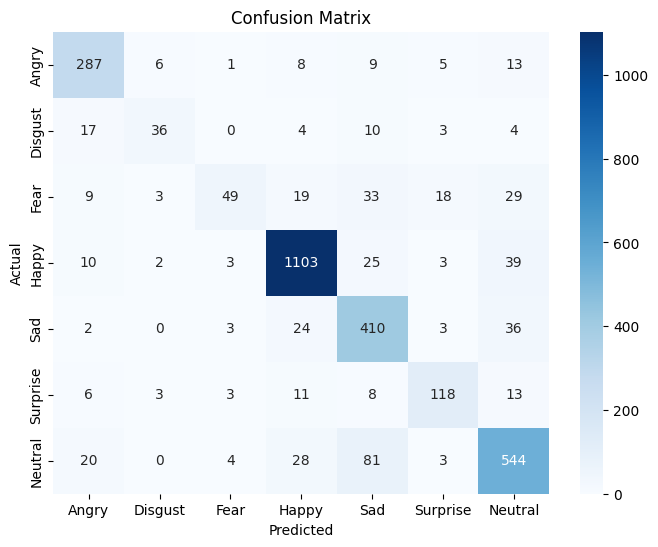

In [14]:
# CONFUSION MATRIX 
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# hitung confusion matrix
cm = confusion_matrix(all_labels, all_preds)

emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotion_names,
            yticklabels=emotion_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [15]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=emotion_names))


              precision    recall  f1-score   support

       Angry       0.82      0.87      0.84       329
     Disgust       0.72      0.49      0.58        74
        Fear       0.78      0.31      0.44       160
       Happy       0.92      0.93      0.93      1185
         Sad       0.71      0.86      0.78       478
    Surprise       0.77      0.73      0.75       162
     Neutral       0.80      0.80      0.80       680

    accuracy                           0.83      3068
   macro avg       0.79      0.71      0.73      3068
weighted avg       0.83      0.83      0.82      3068



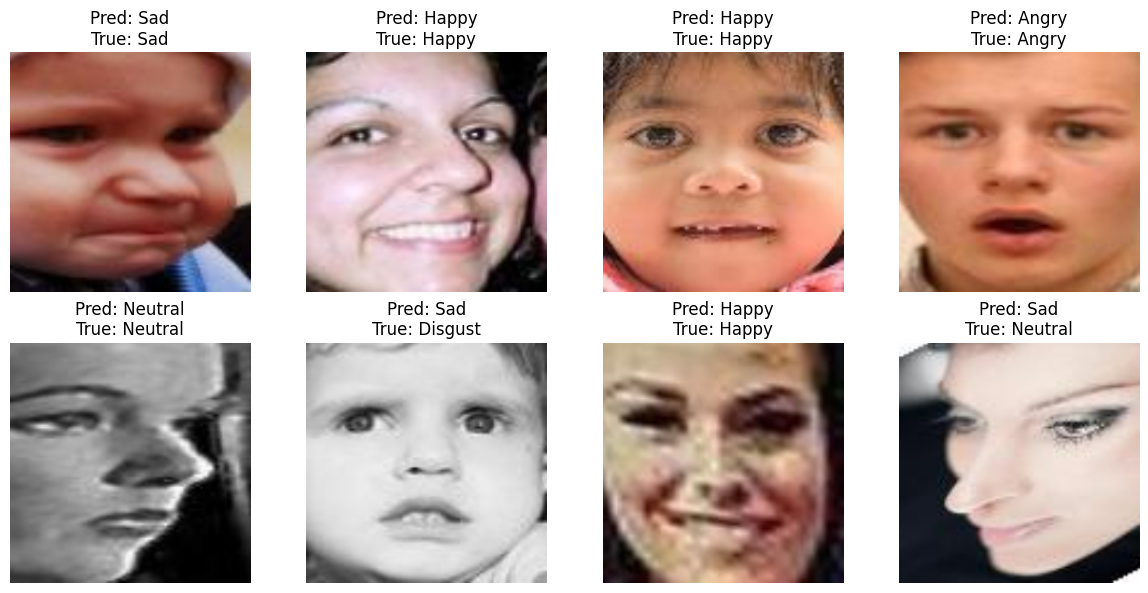

In [16]:
# PREDIKSI CONTOH GAMBAR 

import random

# ambil beberapa sample dari test dataset
samples = random.sample(range(len(test_loader.dataset)), 8)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(samples):
    img, label = test_loader.dataset[idx]
    img_input = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_input)
        _, pred = output.max(1)

    img_np = img.permute(1, 2, 0).numpy()

    plt.subplot(2, 4, i+1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Pred: {emotion_names[pred.item()]}\nTrue: {emotion_names[label]}")
    
plt.tight_layout()
plt.show()


In [17]:
import json

checkpoint_info = {
    "num_classes": 7,
    "labels": emotion_names,
    "input_size": [224, 224],
    "model_file": "emotion_resnet18.pth"
}

with open("checkpoint_info.json", "w") as f:
    json.dump(checkpoint_info, f, indent=4)

print("Checkpoint info saved.")

Checkpoint info saved.
